In [1]:
# Start a neo4j server 
# https://neo4j.com/docs/operations-manual/current/docker/introduction/
#!docker run --restart always --publish=7474:7474 --publish=7687:7687 --env NEO4J_AUTH=neo4j/admin1234 neo4j:5.19.0

In [53]:
# Install dependancies
#%pip install graphdatascience openai neo4j wikipedia langchain matplotlib networkx langchain_experimental json-repair langchain-community

Note: you may need to restart the kernel to use updated packages.


In [75]:
import os
import json
import uuid
import networkx as nx
import matplotlib.pyplot as plt
from langchain import OpenAI
from langchain.docstore.document import Document
from langchain_experimental.graph_transformers.llm import LLMGraphTransformer
from langchain_community.graphs.neo4j_graph import Neo4jGraph, GraphDocument
from pydantic import BaseModel
from neo4j import GraphDatabase
import logging

In [76]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [77]:
# Setting environment variables
os.environ["NEO4J_URI"] = "bolt://localhost:7687" #http://localhost:7474/browser/
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "admin1234"

# Initialize OpenAI client
# Retrieve the OpenAI API key from environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")

In [78]:
# Initialize OpenAI LLM and Graph Transformer
llm = OpenAI(temperature=0, model_name="gpt-4-0613")
llm_transformer = LLMGraphTransformer(llm=llm)

C:\Users\JohnDeHart\anaconda3\envs\twc_api_interactions\lib\site-packages\langchain_community\llms\openai.py:249: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
C:\Users\JohnDeHart\anaconda3\envs\twc_api_interactions\lib\site-packages\langchain_community\llms\openai.py:1070: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(


In [79]:
# Define Node and Relationship Models
class Node(BaseModel):
    id: str
    name: str = ""
    type: str = ""

In [80]:
class Relationship(BaseModel):
    source: Node
    target: Node
    type: str = "RELATION"

In [81]:
# Override the process_response method to handle plain strings
def custom_process_response(self, document):
    nodes_set = {}
    relationships = []

    # Use the LLM model to generate a graph schema
    raw_schema = self.chain.invoke({"input": document.page_content})
    parsed_json = json.loads(raw_schema)

    # Extract nodes and relationships
    for rel in parsed_json:
        head = rel.get("head", "")
        head_type = rel.get("head_type", "")
        tail = rel.get("tail", "")
        tail_type = rel.get("tail_type", "")
        relationship_type = rel.get("relationship", "").replace(" ", "_").upper()

        # Ensure each node has a unique identifier
        if head not in nodes_set:
            nodes_set[head] = Node(id=str(uuid.uuid4()), name=head, type=head_type)
        if tail not in nodes_set:
            nodes_set[tail] = Node(id=str(uuid.uuid4()), name=tail, type=tail_type)

        # Assign a default relationship type if not available
        if not relationship_type:
            relationship_type = "RELATION"

        relationships.append(Relationship(
            source=nodes_set[head],
            target=nodes_set[tail],
            type=relationship_type
        ))

    # Convert to GraphDocument
    graph_document = GraphDocument(
        nodes=list(nodes_set.values()),
        relationships=relationships,
        source=Document(page_content=document.page_content, metadata={"id": document.page_content})
    )

    return graph_document

In [82]:
# Override the process_response method in the LLMGraphTransformer instance
llm_transformer.process_response = custom_process_response.__get__(llm_transformer)

In [83]:
# Sample documents to convert to graph documents (UAVs and weapons relationships)
documents = [
    Document(page_content="The MQ-9 Reaper UAV can carry up to 4 Hellfire missiles."),
    Document(page_content="The MQ-9 Reaper UAV can also carry up to 2 GBU-12 Paveway bombs."),
    Document(page_content="The RQ-4 Global Hawk UAV is used primarily for surveillance and carries no weapons."),
    Document(page_content="The MQ-1 Predator UAV can carry up to 2 Hellfire missiles."),
    Document(page_content="The X-47B UAV is a stealth aircraft and can carry up to 2 JDAM bombs."),
    Document(page_content="The MQ-20 Avenger UAV can carry up to 6 Hellfire missiles and 2 JDAM bombs."),
]

In [84]:
# Extract graph documents from the text
graph_documents = llm_transformer.convert_to_graph_documents(documents)

In [85]:
graph_documents

[GraphDocument(nodes=[Node(id='f33d7750-ca58-4fd6-ac8e-7c1a35078674', type='Product'), Node(id='731bd6c5-c5e5-4329-b136-2595edba7c5e', type='Product')], relationships=[Relationship(source=Node(id='f33d7750-ca58-4fd6-ac8e-7c1a35078674', type='Product'), target=Node(id='731bd6c5-c5e5-4329-b136-2595edba7c5e', type='Product'), type='RELATION')], source=Document(page_content='The MQ-9 Reaper UAV can carry up to 4 Hellfire missiles.', metadata={'id': 'The MQ-9 Reaper UAV can carry up to 4 Hellfire missiles.'})),
 GraphDocument(nodes=[Node(id='b4f2fee0-3a57-4789-8fbc-5e9f45118de6', type='Product'), Node(id='e733cf7a-1abe-491d-884c-0aeca875bf55', type='Product')], relationships=[Relationship(source=Node(id='b4f2fee0-3a57-4789-8fbc-5e9f45118de6', type='Product'), target=Node(id='e733cf7a-1abe-491d-884c-0aeca875bf55', type='Product'), type='RELATION')], source=Document(page_content='The MQ-9 Reaper UAV can also carry up to 2 GBU-12 Paveway bombs.', metadata={'id': 'The MQ-9 Reaper UAV can also c

In [86]:
# Connect to Neo4j database
neo4j_graph = Neo4jGraph(
    url=os.environ["NEO4J_URI"],
    username=os.environ["NEO4J_USERNAME"],
    password=os.environ["NEO4J_PASSWORD"]
)

# ValueError: Could not use APOC procedures. Please ensure the APOC plugin is installed in Neo4j and that 'apoc.meta.data()' is allowed in Neo4j configuration 
# https://stackoverflow.com/questions/42740355/how-to-install-apoc-for-neo4j
#sudo cp /var/lib/neo4j/labs/apoc-4.3.0.3-core.jar /var/lib/neo4j/plugins/
#sudo chown neo4j:neo4j /var/lib/neo4j/plugins/apoc-4.3.0.3-core.jar
#sudo systemctl restart neo4j

# ClientError: {code: Neo.ClientError.Procedure.ProcedureRegistrationFailed} {message: apoc.meta.data is unavailable because it is sandboxed and has dependencies outside of the sandbox. Sandboxing is controlled by the dbms.security.procedures.unrestricted setting. Only unrestrict procedures you can trust with access to database internals.}
# https://stackoverflow.com/questions/48773505/neo4j-install-apoc-and-graph-algorithms-neo-clienterror-procedure-procedureregis
# edit /var/lib/neo4j/conf/neo4j.conf
## dbms.security.procedures.unrestricted=algo.*,apoc.*

In [93]:
# Add graph documents to Neo4j
neo4j_graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

In [94]:
# Query the graph data for visualization
driver = GraphDatabase.driver(
    os.environ["NEO4J_URI"],
    auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
)

In [95]:
def query_graph(tx):
    query = """
    MATCH (a)-[r]->(b)
    WHERE a.name IS NOT NULL AND b.name IS NOT NULL
    RETURN a.name AS from, b.name AS to, type(r) AS relationship
    """
    result = tx.run(query)
    return list(result)

In [96]:
with driver.session() as session:
    graph_data = session.read_transaction(query_graph)

C:\Users\JohnDeHart\AppData\Local\Temp\ipykernel_30100\3898468172.py:2: DeprecationWarning: read_transaction has been renamed to execute_read
  graph_data = session.read_transaction(query_graph)


In [97]:
# Create NetworkX graph with error checking
G = nx.DiGraph()
for record in graph_data:
    if record["from"] and record["to"]:
        G.add_edge(record["from"], record["to"], relationship=record["relationship"])
    else:
        logger.error(f"Invalid record: {record}")

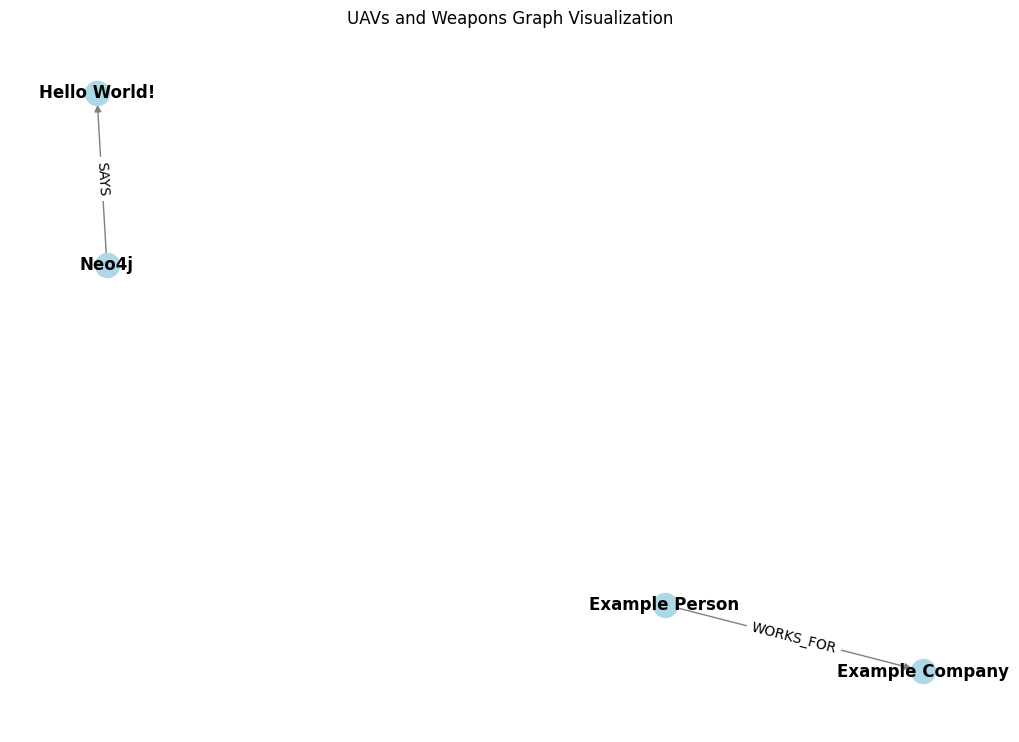

In [98]:
# Plot the graph using NetworkX and Matplotlib
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_color="lightblue", font_size=12, font_weight="bold", edge_color="gray")
edge_labels = nx.get_edge_attributes(G, "relationship")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("UAVs and Weapons Graph Visualization")
plt.show()

In [ ]:
# Close Neo4j connection
driver.close()